In [1]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
from cca_zoo.deepmodels import (
    DCCA,
    DCCA_NOI,
    DCCA_SDL,
    #BarlowTwins,
    get_dataloaders,
    
)
from cca_zoo.deepmodels.utils import architectures, objectives
from cca_zoo.plotting import pairplot_label
from cca_zoo.data import CCA_Dataset
from cca_zoo.models import CCA
from cca_zoo.model_selection import GridSearchCV
import torch.optim as optim
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import os
from scipy.spatial import distance
from scipy.stats import pearsonr
from scipy.stats import fisher_exact
from scipy.stats.contingency import crosstab
from scipy.stats import hypergeom
import random
import pandas as pd
import numpy as np
import pickle
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import seed_everything
from torch import nn

os.chdir('../raw_data')


#### Functions to load and or write to pickle files

In [2]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [3]:
# load df with all info
path = './df_classes_max3_embeddings.pickle'
df_all = Files(path).load_pickle()#[:1000] #just a subset for scripting
df_all.shape

(41447, 8)

In [3]:
class DeepCCA:
    def __init__(self, df_all,batch_size = 768,num_workers = 6,\
                latent_dims=100, epochs=300, lr=0.001): #default dims determined after optimisation
        
        self.df_all = df_all
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.v1='ms2ds'
        self.v2 = 'mol2vec'
        
        self.epochs = epochs
        self.sdl_lr = 0.025118864315095822#0.01#lr (picked after running lr_finder) auto lr enabled
        self.dcca_lr = 5.623413251903491e-08 #lr
        self.latent_dims=latent_dims
        self.optim = 'sgd'
        self.activation = nn.Tanh()
        self.objective = objectives.CCA
        self.encoder_1_layers = (500,500)
        self.encoder_2_layers = (500,500)
        #seed_everything(15) # seeding is not decide to test model reproducibility
        
        
    def split_data(self,test_size=0.2,\
                   random_state=None,stratify=None): # thinking of removing this one
        
        if random_state != None and stratify == None:
            train_df, test_df = \
            train_test_split(self.df_all, test_size=test_size, random_state=random_state)
        
        elif random_state == None and stratify != None:
            train_df, test_df = \
            train_test_split(self.df_all, test_size=test_size,stratify=self.df_all[stratify])
        else:
            train_df, test_df = \
            train_test_split(self.df_all, test_size=test_size, random_state=42)
        
        return train_df, test_df 
    
    def gen_views(self,v1='ms2ds',v2='mol2vec'):
        
        #split test, train
        train_df, test_df= self.split_data(test_size=0.2,random_state=42)
        
        #Split train dataset into train and validation set
        train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
        
        
        #extract the 2 view, v1 == spectra embeddings, v2==structure embeddings
        v1_train, v1_test = np.array([x for x in train_df[v1]]), np.array([x for x in test_df[v1]])
        v2_train, v2_test = np.array([x for x in train_df[v2]]), np.array([x for x in test_df[v2]])

        # validation
        v1_val, v2_val = np.array([x for x in val_df[v1]]), np.array([x for x in val_df[v2]])
        
        #update self dfs
        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df
        
        # not memory efficient !!!
        self.v1_train, self.v1_test = v1_train, v1_test
        self.v2_train, self.v2_test = v2_train, v2_test
        self.v1_val, self.v2_val = v1_val, v2_val
        
        return None
    
    def deepcca_encoders(self):
        # define encoders
        self.encoder_1 = architectures.Encoder(
                                      latent_dims = self.latent_dims, 
                                      feature_size = self.v1_size,
                                      layer_sizes = self.encoder_1_layers,
                                      activation = self.activation
                                    )
                                     
        self.encoder_2 = architectures.Encoder(
                                      latent_dims=self.latent_dims, 
                                      feature_size=self.v2_size, 
                                      layer_sizes=self.encoder_2_layers,
                                      activation = self.activation
                                     )
       
        return None#[encoder_1, encoder_2]
        
    
    def deepcca_dataloaders(self):
        
        #v1_train,v1_test, v2_train,v2_test, v1_val, v2_val = \
        self.gen_views(v1=self.v1, v2=self.v2)
        
        #creat CCA dataset 
        train_dataset = CCA_Dataset([self.v1_train, self.v2_train])
        test_dataset = CCA_Dataset([self.v1_test, self.v2_test])
        val_dataset = CCA_Dataset([self.v1_val, self.v2_val])
        
        #update features size
        self.v1_size = self.v1_train.shape[1]
        self.v2_size = self.v2_train.shape[1]
        self.N = len(train_dataset)
        
        #set N (for sdl; equal len train dataset)
        self.N = len(train_dataset)
        
        #loaders
        self.train_loader , self.val_loader = get_dataloaders(train_dataset, \
                                                    val_dataset,batch_size=self.batch_size,\
                                                    num_workers=self.num_workers,drop_last=False)
        self.test_loader = get_dataloaders(test_dataset,\
                                      batch_size=self.batch_size, \
                                      num_workers=self.num_workers,drop_last=False)
        
        
        
        
        return None
    
    
    def train_cca(self): #only for comparison with other deep models
        
       
        
        #define and train cca model
        print('\n','-'*20,'\n Training CCA\n','-'*20)
        cca = CCA(latent_dims=self.latent_dims).fit((self.v1_train, self.v2_train))
        self.cca = cca
        return None#cca
    
    def train_sdl(self, checkpoint=None, logger=None,lam=0.0001,enable_progress_bar=True ):
        
        
        # 2. SDL
        sdl = DCCA_SDL(self.latent_dims,
                       optimizer=self.optim,
                       N=self.N, 
                       encoders = [self.encoder_1,self.encoder_2],
                       lam=0.0001, 
                       lr=self.sdl_lr,
                       dropout=0.05,
                       objective=self.objective) 

        
        
        #define the trainer
        
        self.trainer = pl.Trainer(#default_root_dir=default_root_dir,
                             logger = logger,
                             max_epochs=self.epochs, #enable early stoppage instead of specifiying num epochs                           
                             log_every_n_steps=1,
                             val_check_interval = 1, #`Trainer(val_check_interval=1)` was configured so validation will run after every batch.
                             
                             callbacks=[
                                checkpoint,
                                 #pl.callbacks.early_stopping.EarlyStopping(monitor="val/l2") # early stopage to reduce overfitting
                             ],
                            enable_progress_bar=enable_progress_bar,
                            auto_lr_find = True
                                )#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting
        
        print('\n','-'*20,'\n Training SDL\n','-'*20)
        self.trainer.fit(sdl, self.train_loader,self.val_loader)
        self.sdl = sdl
        return None#sdl
    
    def train_dcca(self):
        
       
        
        # 2. DCCA
        dcca = DCCA(self.latent_dims,
                    optimizer=self.optim,
                    encoders = [self.encoder_1,self.encoder_2],
                    lr=self.dcca_lr,
                    objective=self.objective) 

        #train
        #tb_logger = pl_loggers.TensorBoardLogger(save_dir="pl_logs/dcca")
        trainer = pl.Trainer(default_root_dir="./dcca",max_epochs=self.epochs,log_every_n_steps=1)#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting

        print('\n','-'*20,'\n Training DCCA\n','-'*20)
        trainer.fit(dcca, self.train_loader,self.val_loader)
        
        self.dcca = dcca
        
        return None #dcca
    
    
    
    def score(self,model,dataset): 
        """
        model: either 'cca', 'dcca', 'sdl'
        dataset: 'train', 'test', or 'val'
        
        returns: correlation 
        """
       # for cca models 
        #m = eval(model)
        
        #specify data to transform
        if dataset == 'train':
            v1,v2, loader = self.v1_train, self.v2_train, self.train_loader
        elif dataset == 'test':
            v1,v2, loader = self.v1_test, self.v2_test, self.test_loader
        elif dataset == 'val':
            v1,v2, loader = self.v1_val, self.v2_val, self.val_loader
        
        if model == 'cca':
            corr = self.cca.score([v1,v2])
        
        if model == 'sdl':
            corr = self.sdl.score(loader)
        
        elif model == 'dcca':
            corr = self.dcca.score(loader)
       
        return corr
    def update_z_scores(self,dataset, z1,z2,cols):
        #update train df with transformed z scores
            if dataset == 'train':
                
                self.train_df[cols[0]] = [x for x in z1]
                self.train_df[cols[1]] = [x for x in z2]
                
            #update test df
            if dataset == 'test':
                self.test_df[cols[0]] = [x for x in z1]
                self.test_df[cols[1]] = [x for x in z2]
            
            #update val df
            if dataset == 'val':
                self.val_df[cols[0]] = [x for x in z1]
                self.val_df[cols[1]] = [x for x in z2]
            return None
                
        
    
    def transform(self,model,dataset):
        """
        model: either 'cca', 'dcca', 'sdl': of course the model must have been fitted :)
        loader: is similar data loader used to train either sdl/dcca
        dataset: either 'train', 'test', 'val'
        
        returns transformed data; view1,view2
        """
        
        #specify data to transform
        if dataset == 'train':
            v1,v2, loader = self.v1_train, self.v2_train, self.train_loader
        elif dataset == 'test':
            v1,v2, loader = self.v1_test, self.v2_test, self.test_loader
        elif dataset == 'val':
            v1,v2, loader = self.v1_val, self.v2_val, self.val_loader
        
        
        #specify the model for transformation
        if model == 'cca':
            z1,z2 = self.cca.transform([v1,v2]) #transform
            self.update_z_scores(dataset,z1,z2,cols=['cca_z1','cca_z2']) # update the df with z scores            
    
            
        if model == 'sdl':
            z1,z2 = self.sdl.transform(loader)
            self.update_z_scores(dataset,z1,z2,cols=['sdl_z1','sdl_z2'])
                
        
        if model == 'dcca':
            z1,z2 = self.dcca.transform(loader)
            self.update_z_scores(dataset,z1,z2,cols=['dcca_z1','dcca_z2'])
        
        
        return None##z1,z2; can be found in self.<df[model_z]>       
        

In [128]:
# # #drop inchikeys appering once, to make it possible to stratify based on inchikey
# df_all = df_all.groupby('cf_class').filter(lambda x : len(x)>=2)
# df_all.shape

# 1. Train CCA Model; for comparison with DeepModels

##### 1.1 Initiate DeepCCA Models object

In [10]:
# Initiate deepcca objec
Models = DeepCCA(df_all)

# generate data loaders and cca v1,v2
Models.deepcca_dataloaders()

# set up the encoders
Models.deepcca_encoders()

In [11]:
Models.N

720

In [130]:
%%time
# train cca
Models.train_cca() # will look at this for opti

# score the models: it runs cca.score
cca_train_corr = Models.score(model='cca', dataset='train')
cca_test_corr  = Models.score(model='cca', dataset='test')

#cca transform: runs cca.transform and update the df with z scores
Models.transform(model='cca', dataset='train')
Models.transform(model='cca', dataset='test')
Models.transform(model='cca', dataset='val')



 -------------------- 
 Training CCA
 --------------------
Wall time: 54 ms


# 2. Find Optimal Learning rate for SDL model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



 -------------------- 
 Finding opt SDL lr 
 --------------------


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at C:\Users\lmeli\Desktop\Thesis\raw_data\.lr_find_c3dea192-4b27-45ca-b1ae-e957c5001525.ckpt


Wall time: 58.2 s


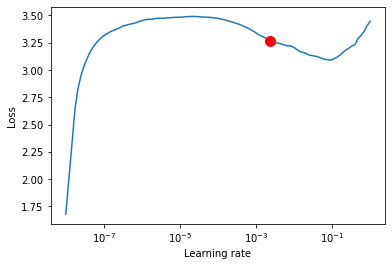

In [51]:
%%time
# Define sdl; only for finding optimal lr
sdl = DCCA_SDL(Models.latent_dims,optimizer='sgd',
                N=Models.N, encoders=[Models.encoder_1,Models.encoder_2],
                lam=0.0001, 
                objective=objectives.CCA) # train size

#define sdl trainer only for finding opt lr
trainer_sdl = pl.Trainer(
        max_epochs=Models.epochs, log_every_n_steps=1)

print('\n','-'*20,'\n Finding opt SDL lr \n','-'*20)

# run lr finder
lr_finder = trainer_sdl.tuner.lr_find(sdl,Models.train_loader,
                                      Models.val_loader,
                                      early_stop_threshold=None)
#update sdl lr
Models.sdl_lr = lr_finder.suggestion()
#plot lr suggestion
fig = lr_finder.plot(suggest=True)


In [52]:
Models.sdl_lr


0.0022908676527677745

# 3. Find Optimal Learning rate for DCCA model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



 -------------------- 
 Finding opt DCCA lr 
 --------------------


Finding best initial lr:   0%|          | 0/128 [00:00<?, ?it/s]

Restoring states from the checkpoint path at C:\Users\lmeli\Desktop\Thesis\raw_data\.lr_find_a431448d-58be-4589-beeb-86416c70c7c8.ckpt


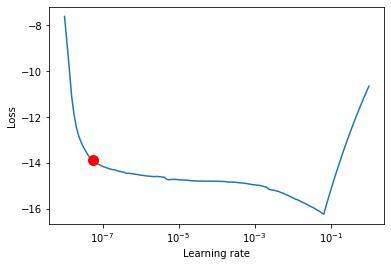

In [50]:
# Define dcca; only for finding optimal lr
dcca = DCCA(
        latent_dims=Models.latent_dims,
        encoders=[Models.encoder_1, Models.encoder_2],
        objective=objectives.CCA,
        optimizer='sgd',
        lr=Models.dcca_lr)

#define dcca trainer only for finding opt lr
trainer_dcca = pl.Trainer(
        max_epochs=Models.epochs, log_every_n_steps=1)

print('\n','-'*20,'\n Finding opt DCCA lr \n','-'*20)

# run lr finder
lr_finder = trainer_dcca.tuner.lr_find(dcca,Models.train_loader,Models.val_loader,
                                       early_stop_threshold=None,num_training=128)
#update dcca lr
Models.dcca_lr = lr_finder.suggestion()
#plot lr suggestion
fig = lr_finder.plot(suggest=True)


In [51]:
Models.dcca_lr

5.623413251903491e-08

In [1]:
version =  'sdl_run_768_only_backup'
   
experiment_dir = './sdl_logs'
model_checkpoint = ModelCheckpoint(save_last=True,
                                       monitor="val/l2",
                                       mode = 'min')

logger = TensorBoardLogger(save_dir=experiment_dir, 
                                   name='sdl_optimal_batch_size',
                                   version = version)
    # train sdl
Models.train_sdl(model_checkpoint, logger)
#sdl_run_768 transform: runs cca.transform and update the df with z scores
Models.transform(model='sdl', dataset='train')
Models.transform(model='sdl', dataset='test')

In [54]:
paths = ['./sdl_768_max3_train_z',
        './sdl_768_max3_test_z']
Files(paths[0]).wwrite_to_file_file_to_fileto_file(Models.train_df)
Files(paths[1]).write_to_file(Models.test_df)

### GIVE Details on tensorboard and checkpoints !!!!

In [54]:

%load_ext tensorboard
%tensorboard --logdir=./sdl_logs/sdl_optimal_batch_size --host localhost --port 8082
   

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# 4. Find optimal batch_size for SDL

##### 4.1 Train models with different batch size

loop [128, 256,384,512,640,768]

In [2]:
%%time
for i in range(6):
    print(f'Testing bath_size: {128*(i+1)}')
    Models.batch_size = 128 * (i+1) 
    
    version =  f'sdl_batch_size_{128*(i+1)}'
   
    experiment_dir = './sdl_logs'
    model_checkpoint = ModelCheckpoint(save_last=True,
                                       monitor="val/l2",
                                       mode = 'min')

    logger = TensorBoardLogger(save_dir=experiment_dir, 
                                   name='sdl_optimal_batch_size',
                                   version = version)
    # train sdl
    Models.train_sdl(model_checkpoint, logger) 

  

##### 4.2 Load the trained model from checkpoint

Documentation on loading pytorch lightning model from a checkpoint can be found [here](https://pytorch-lightning.readthedocs.io/en/stable/common/checkpointing_basic.html)


From the tensorboard we observe that the batch size of 128 shows signs of 'learning' (metrics improve along training) while the larger batch_sizes do not show improvements along training.

Here I load the models, sdl_batch_size_128 (sdl_128)...sdl_batch_size_768 (sdl_768) and see how there transformations compare

In [60]:

sdl = DCCA_SDL(latent_dims = Models.latent_dims,N=Models.N) # set up the model base


models = [] # [sdl_128, sdl_256, ...sdl_768]
for i in range(6):
    model = sdl.load_from_checkpoint(f'./sdl_logs/sdl_optimal_batch_size/sdl_batch_size_{128*(i+1)}/checkpoints/last.ckpt',
                                 
                                 latent_dims = Models.latent_dims, N=Models.N, 
                                 optimizer=Models.optim,
                                 encoders = [Models.encoder_1,Models.encoder_2],
                                 lam=0.0001, 
                                 dropout=0.05,
                                 objective=Models.objective
                                 )
    model.eval() # to drop randomness as mentioned in documentation
    models.append(model)


models[0]

DCCA_SDL(
  (encoders): ModuleList(
    (0): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=200, out_features=500, bias=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
        (1): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=500, out_features=300, bias=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
        (2): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=300, out_features=300, bias=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (fc): Sequential(
        (0): Dropout(p=0, inplace=False)
        (1): Linear(in_features=300, out_features=15, bias=True)
      )
    )
    (1): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=300, out_features=500, bias=True)
        

##### 4.3 Transform dataset using batch size optimised  models

In [23]:
%%time
models = [sdl_128,sdl_256,sdl_384,sdl_512,sdl_640,sdl_768]

for i, model in enumerate(models):
    z1_test, z2_test = model.transform(loader=Models.test_loader) # get test z transformations
    z1_train, z2_train = model.transform(loader=Models.train_loader) # get train z transformations
    z1_val, z2_val = sdl_768.transform(loader=Models.val_loader) # get val z transformations


    #update the df with z score from the sdl_128
    # 1. update test_df
    Models.update_z_scores(dataset='test',z1=z1_test,
                       z2=z2_test, 
                       cols=[f'sdl_{128*(i+1)}_z1',f'sdl_{128*(i+1)}_z2'])
    # 2. update train_df
    Models.update_z_scores(dataset='train',z1=z1_train,
                       z2=z2_train, 
                       cols=[f'sdl_{128*(i+1)}_z1',f'sdl_{128*(i+1)}_z2'])



    # 3. update val_df

    Models.update_z_scores(dataset='val',z1=z1_val,
                       z2=z2_val, 
                       cols=[f'sdl_{128*(i+1)}_z1',f'sdl_{128*(i+1)}_z2'])

#write the transformed df to file for 
dfs = [Models.train_df, Models.test_df]
paths = ['./train_df_max3_sdl_and_cca_batch_128_to_768_15_dim_z',
         './test_df_max3_sdl_and_cca_batch_128_to_768_15_dim_z']
for path, df in zip(paths,dfs):
    Files(path).write_to_file(df)

Wall time: 2.03 s


# 5. Find optimal dimensions for SDL

##### 5.1 Train models with different setting of latent dimensions

In [131]:
%%time
#dims = [10,20,30,40,50] #already tested these ones
dims = [100,200,300] # time to test higher dims
for dim in dims:
    print(f'Training dims: {dim}')
    
    # latent_dims deepcca objec
    Models = DeepCCA(df_all)
    
    #set the latent dimentions to dim
    Models.latent_dims = dim
    
    # generate data loaders and cca v1,v2
    Models.deepcca_dataloaders()

    # set up the encoders
    Models.deepcca_encoders()
    
    #set up logger
    version =  f'sdl_dims_{dim}'
   
    experiment_dir = './sdl_logs/sdl_optimal_dims/'
    
    model_checkpoint = ModelCheckpoint(save_last=True,
                                       monitor="val/l2",
                                       mode = 'min')

    logger = TensorBoardLogger(save_dir=experiment_dir, 
                                   name='sdl_optimal_dims',
                                   version = version)
    # train sdl
    Models.train_sdl(model_checkpoint, logger) 
    #break

##### 5.2 Load the dimensions optimised models from checkpoint

In [22]:
models = []
dims = [10,20,30,40,50, 100,200, 300]
for dim in dims:
    # Initiate deepcca objec
    Models = DeepCCA(df_all)
    
    #set the latent dimentions to dim
    Models.latent_dims = dim
    
    # generate data loaders and cca v1,v2
    Models.deepcca_dataloaders()

    # set up the encoders
    Models.deepcca_encoders()

    sdl = DCCA_SDL(latent_dims = dim,N=Models.N) # set up the model base
    
    model = sdl.load_from_checkpoint(f'./sdl_logs/sdl_optimal_dims/sdl_optimal_dims/sdl_dims_{dim}/checkpoints/last.ckpt',
                                 
                                 latent_dims = Models.latent_dims, N=Models.N, 
                                 optimizer=Models.optim,
                                 encoders = [Models.encoder_1,Models.encoder_2],
                                 lam=0.0001, 
                                 dropout=0.05,
                                 objective=Models.objective
                                 )
    model.eval() # to drop randomness as mentioned in documentation
    models.append(model)


Global seed set to 15
Global seed set to 15
Global seed set to 15
Global seed set to 15
Global seed set to 15
Global seed set to 15
Global seed set to 15
Global seed set to 15


##### 5.3 Transform dataset using the dimensions optimised models

In [1]:
dims_corr = []
dims = [10,20,30,40,50,100,200,300]
for i, model in enumerate(models):
    
    z1_test, z2_test = model.transform(loader=Models.test_loader) # get test z transformations
    z1_train, z2_train = model.transform(loader=Models.train_loader) # get train z transformations
    z1_val, z2_val = model.transform(loader=Models.val_loader) 
    test_corr = model.score(Models.test_loader)
    dims_corr.append(test_corr)
    #update the df with z score from the sdl_128
    # 1. update test_df
    Models.update_z_scores(dataset='test',z1=z1_test,
                       z2=z2_test, 
                       cols=[f'sdl_dims_{dims[i]}_z1',f'sdl_dims_{dims[i]}_z2'])
    # 2. update train_df
    Models.update_z_scores(dataset='train',z1=z1_train,
                       z2=z2_train, 
                       cols=[f'sdl_dims_{dims[i]}_z1',f'sdl_dims_{dims[i]}_z2'])



    # 3. update val_df

    Models.update_z_scores(dataset='val',z1=z1_val,
                       z2=z2_val, 
                       cols=[f'sdl_dims_{dims[i]}_z1',f'sdl_dims_{dims[i]}_z2'])
    #break

    
    
    
#write the transformed df to file for the 
dfs = [Models.train_df, Models.test_df, Models.val_df]
paths = ['./sdl_logs/sdl_optimal_dims/train_df_max3_sdl_dims_optimised_z_scores.pickle',
         './sdl_logs/sdl_optimal_dims/test_df_max3_sdl_dims_optimised_z_scores.pickle',
         './sdl_logs/sdl_optimal_dims/val_df_max3_sdl_dims_optimised_z_scores.pickle'
        ]
for path, df in zip(paths,dfs):
    Files(path).write_to_file(df)
Models.test_df.head()

##### 5.4 Compare different latent dimensions between CCA, DCCA and SDL 

In [4]:
%%time
corr = []

dims = [10, 20, 30, 40, 50] # we already found that more than 50 is not good choice

for dim in dims:
    
    # latent_dimste deepcca objec
    Models = DeepCCA(df_all)
    
    #set the latent dimentions to dim
    Models.latent_dims = dim
    
    # generate data loaders and cca v1,v2
    Models.deepcca_dataloaders()

    # set up the encoders
    Models.deepcca_encoders()
    
    # train cca
    Models.train_cca() # will look at this for opti

    # score the models: it runs cca.score

    cca_train_corr = Models.score(model='cca', dataset='train')
    cca_test_corr = Models.score(model='cca', dataset='test')

    corr.append([f'cca_dims_{dim}',cca_train_corr, cca_test_corr])
    
    
    # train sdl
    Models.train_sdl() # will look at this for opti

    # score the models: it runs sdl.score()

    sdl_train_corr =Models.score(model='sdl', dataset='train')
    sdl_test_corr = Models.score(model='sdl', dataset='test')

    corr.append([f'sdl_dims_{dim}',sdl_train_corr, sdl_test_corr])

    
    # train dcca
    Models.train_dcca() # will look at this for opti

    # score the models: it runs dcca.score()

    dcca_train_corr =Models.score(model='dcca', dataset='train')
    dcca_test_corr = Models.score(model='dcca', dataset='test')

   
    corr.append([f'dcca_dims_{dim}',dcca_train_corr, dcca_test_corr])
    

###### 5.5 Plot the test correlation from the tried dims for each model

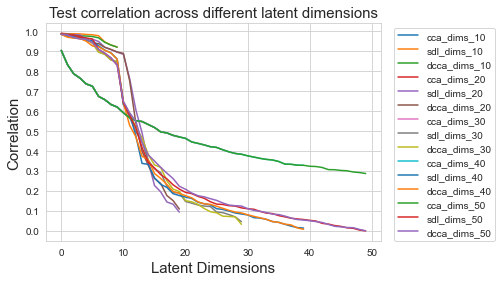

In [32]:
legend = [x[0] for x in corr]
fig, ax = plt.subplots()
sns.set_style('whitegrid')
for cor in corr:
    sns.lineplot(x=[x for x in range(len(cor[1]))],
                                     y=cor[1],\
                 #color = palette[i],
                 #linestyle=line[1], 
                                     ax=ax)
    plt.legend(labels=legend,loc=(1.04, 0.0),title='Model')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Test correlation across different latent dimensions', fontsize=15)
plt.show()

# 6. Find optimal number of hidden layers for SDL


###### 6.1 Train models with different number of layers

The input layer size is always equal to the input feature size

The output layer size is always equal to the latent_dimensions:



The plan is to start with a simple model with a single hidden layer with size equal to the average of input layer size and ouput layer size

In [2]:
%%time
# loop through the layer sizes
corr = {}
for run in range(5): # reapiting 5 times to test whether it is reproducible
    
    for i in range(1,6): #test number of hidden layers from 1:5
    
        print('\*'*21)
        print(f'\nSTARTING SDL WITH LAYERS: {i} RUN {run}\n')
        print('*/'*21)
        
        # Initiate deepcca objec
        Models = DeepCCA(df_all)

        # generate data loaders and cca v1,v2
        Models.deepcca_dataloaders()

        # set up the encoders
        Models.deepcca_encoders()
        
        print(Models.train_df.shape)
        
            
        #set layer number
        # layer size is generally recommended to be an average of input size and output size
        # see this discussion: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    
        # so i set the layer size all to be equal as an average of input and output size
        Models.encoder_1_layers = (int(np.mean([Models.v1_size,Models.latent_dims])),)*i
        Models.encoder_2_layers = (int(np.mean([Models.v2_size,Models.latent_dims])),)*i
    
        # set up the encoders
        Models.deepcca_encoders()
    
        #set up logger
        version =  f'sdl_layers_{len(Models.encoder_1_layers)}'
   
        experiment_dir = './sdl_logs'
    
        model_checkpoint = ModelCheckpoint(save_last=True,
                                       monitor="val/l2",
                                       mode = 'min')
    
        logger = TensorBoardLogger(save_dir=experiment_dir, 
                                   name='sdl_optimal_layers',
                                   version = version)
        # train sdl
        Models.train_sdl(model_checkpoint, logger,enable_progress_bar=False) # disable progress bar to avoid crushing the notebook
        test_corr  = Models.score(model='sdl', dataset='test')
       
        # add test correlation to a dict for averaging later
        if i not in corr.keys():
            corr[i] = []
            corr[i].append(test_corr)
        else:
            corr[i].append(test_corr)
       
  

Files('./sdl_logs/sdl_optimal_layers/test_correlation_dict_for_layer_runs_no_random_seeds.pickle').write_to_file(corr)

In [6]:
corr = Files('./sdl_logs/sdl_optimal_layers/test_correlation_dict_for_layer_runs_no_random_seeds.pickle').load_pickle()
corr.keys()

dict_keys([1, 2, 3, 4, 5])

###### 6.2 Plot average test correlation from the 5 runs

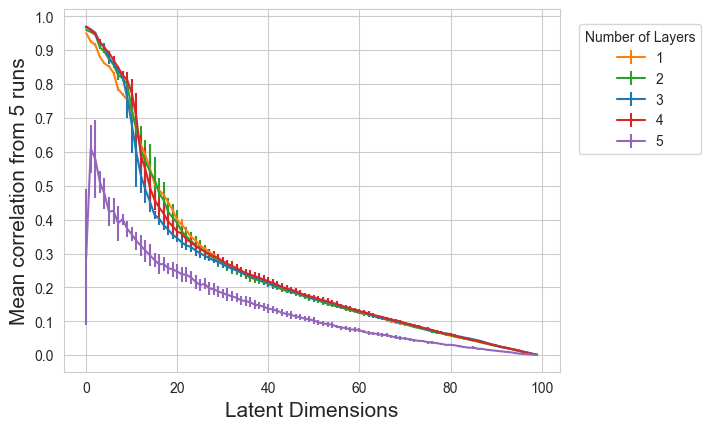

In [19]:
#unpack the test correlation from th 5 runs
mean_corr = []
std_corr = []
for key, val in corr.items():
 
    cor = np.mean(val,axis=0) # take average of each dim for the 5 runs (element-wise for dimensions)
    std = np.std(val, axis=0) # take the standard deviation along the dimensions
    mean_corr.append(cor)
    std_corr.append(std)
    #break
len(mean_corr)
palette = [sns.color_palette()[1],
           sns.color_palette()[2],
           sns.color_palette()[0],
           sns.color_palette()[3],
           sns.color_palette()[4],
          ]


#plot test correlation (average of 5 runs)
legend = [1,2,3,4,5]
fig, ax = plt.subplots(figsize=(6.4, 4.8),dpi=100)
sns.set_style('whitegrid')
#plt.figure(figsize=(6.4, 4.8),dpi=100)
for i, (cor, std) in enumerate(zip(mean_corr, std_corr)):
    plt.errorbar( x= [x for x in range(100)],  y=cor, yerr=std, color=palette[i] ,            
             #ecolor='red',
            ecolor=palette[i])
    
#     sns.lineplot(x=[x for x in range(len(cor))],
#                                      y=cor,\
#                  #color = palette[i],
#                  #linestyle=line[1], 
#                                      ax=ax)

    plt.legend(labels=legend,loc=(1.04, 0.6),title='Number of Layers')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Mean correlation from 5 runs', fontsize=15)
plt.savefig('./sdl_logs/figures/number_of_layers_corr.pdf',dpi=100, format='pdf',
           transparent=False,bbox_inches = 'tight')
plt.show()

###### 6.3 Average correlation across all the dimensions

In [94]:
totals_mean = []
totals_sd = []
for key, val in corr.items():
    
    cor = np.mean(val,axis=1) # take average for all the dimensions
    std = np.std(cor) # take the standard deviation along the dimensions
    totals_mean.append(cor)
    totals_sd.append(std)

    

In [5]:
# barplot would have been better but this values are just too small
plt.figure(figsize=(6.4, 4.8),dpi=100)
for x in totals_mean:
    sns.scatterplot(y=x, x=['1', '2','3','4','5'])
plt.legend(labels=legend,loc=(1.04, 0.6),title='Number of Layers')
plt.xlabel('Runs', fontsize=13)
plt.ylabel('Mean correlation across all dimensions', fontsize=13)
plt.ylim(0.3, 0.6)
plt.show()

###### 6.4 Load models optimized for number of layers

In [26]:
models = []

for i in range(1,6):
    # Initiate deepcca objec
    Models = DeepCCA(df_all)
    
    # generate data loaders and cca v1,v2
    Models.deepcca_dataloaders()

    
    # set the model layers based on what it was trained on
    Models.encoder_1_layers = (int(np.mean([Models.v1_size,Models.latent_dims])),)*i
    Models.encoder_2_layers = (int(np.mean([Models.v2_size,Models.latent_dims])),)*i
    
    
    # set up the encoders
    Models.deepcca_encoders()

    sdl = DCCA_SDL(latent_dims = Models.latent_dims,N=Models.N) # set up the model base
    
    model = sdl.load_from_checkpoint(f'./sdl_logs/sdl_optimal_layers/sdl_layers_{i}/checkpoints/last.ckpt',
                                 
                                 latent_dims = Models.latent_dims, N=Models.N, 
                                 optimizer=Models.optim,
                                 encoders = [Models.encoder_1,Models.encoder_2],
                                 lam=0.0001, 
                                 dropout=0.05,
                                 objective=Models.objective
                                 )
    model.eval() # to drop randomness as mentioned in documentation
    models.append(model)

In [28]:
models[0]

DCCA_SDL(
  (encoders): ModuleList(
    (0): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=200, out_features=107, bias=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (fc): Sequential(
        (0): Dropout(p=0, inplace=False)
        (1): Linear(in_features=107, out_features=15, bias=True)
      )
    )
    (1): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=300, out_features=157, bias=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (fc): Sequential(
        (0): Dropout(p=0, inplace=False)
        (1): Linear(in_features=157, out_features=15, bias=True)
      )
    )
  )
  (mse): MSELoss()
  (bns): ModuleList(
    (0): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): BatchNorm1d(15, eps=1e-05, momentum=0.1, 

###### 6.5 Transform the dataset 

In [20]:
#transforming with layer optimized models
corr = []
for i, model in enumerate(models):
    
    #calculate the correlation from models with different layers
    
    sdl_train_corr =model.score(Models.train_loader)
    sdl_test_corr = model.score(Models.test_loader)
    corr.append([sdl_train_corr,sdl_test_corr])
    
    # transforma
    z1_test, z2_test = model.transform(loader=Models.test_loader) # get test z transformations
    z1_train, z2_train = model.transform(loader=Models.train_loader) # get train z transformations
    z1_val, z2_val = model.transform(loader=Models.val_loader) 
    
    
       #update the df with z score from the sdl_128
    # 1. update test_df
    Models.update_z_scores(dataset='test',z1=z1_test,
                       z2=z2_test, 
                       cols=[f'sdl_layers_{i+1}_z1',f'sdl_layers_{i+1}_z2'])
    
    # 2. update train_df
    Models.update_z_scores(dataset='train',z1=z1_train,
                       z2=z2_train, 
                       cols=[f'sdl_layers_{i+1}_z1',f'sdl_layers_{i+1}_z2'])



    # 3. update val_df

    Models.update_z_scores(dataset='val',z1=z1_val,
                       z2=z2_val, 
                       cols=[f'sdl_layers_{i+1}_z1',f'sdl_layers_{i+1}_z2'])
    #break

    
    
    
#write the transformed df to file for the 
dfs = [Models.train_df, Models.test_df, Models.val_df]
paths = ['./sdl_logs/sdl_optimal_layers/train_df_max3_sdl_layers_optimised_z_scores.pickle',
         './sdl_logs/sdl_optimal_layers/test_df_max3_sdl_layers_optimised_z_scores.pickle',
         './sdl_logs/sdl_optimal_layers/val_df_max3_sdl_layers_optimised_z_scores.pickle'
        ]
for path, df in zip(paths,dfs):
    Files(path).write_to_file(df)


In [19]:
Models.val_df.head(2)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,sdl_layers_1_z1,sdl_layers_1_z2,sdl_layers_2_z1,sdl_layers_2_z2,sdl_layers_3_z1,sdl_layers_3_z2,sdl_layers_4_z1,sdl_layers_4_z2,sdl_layers_5_z1,sdl_layers_5_z2
18308,CC1(CCCCC1)C(=O)Nc2ccc(c(c2Cl)Cl)O,VDLGAVXLJYLFDH-UHFFFAOYSA-N,VDLGAVXLJYLFDH,spec_id16769,"[28.992814519957395, 9.93094121359686, -16.288...","[24.41728973388672, 18.567832946777344, 0.9911...","[1.1145527, -1.4718719, -1.1575501, 1.5242243,...",Benzene and substituted derivatives,"[0.7962772, -0.07153203, 0.56734025, -0.518569...","[0.8773907, -0.2818244, 0.1881715, -0.39703363...","[-0.110258184, 0.047015995, 0.005015798, -1.19...","[-0.23802324, 0.11730917, -0.19891953, -0.8054...","[-0.6273837, 0.23206854, -0.75163007, -0.41878...","[-0.5412555, 0.43494806, -0.70290864, -0.47115...","[0.15174851, -0.2964838, -0.06400095, -0.79210...","[0.30865642, -0.3446151, -0.17560902, -0.26335...","[-0.13009155, -0.75716096, 0.01922381, -0.2401...","[-0.4688363, -0.08296201, 0.49244732, -0.31242..."
16161,[H]N1C(=O)C([H])(C([H])([H])[H])C([H])(OC(=O)C...,VJYQPLSJYQMFHT-UHFFFAOYSA-N,VJYQPLSJYQMFHT,spec_id14610,"[7.295793570022209, 5.1959969017812835, 22.963...","[0.0, 0.0, 9.470010757446289, 54.8682708740234...","[3.5072234, -8.692439, -8.4471245, 5.7731876, ...",Peptidomimetics,"[-0.7580992, -0.32199973, 1.3465203, -0.231600...","[-0.6036781, -0.25254858, 0.7587187, 0.3202361...","[4.0607224, -0.0035479963, 4.157552, -0.949395...","[5.788162, 0.030245155, 6.148678, -0.30525267,...","[-0.3406075, 0.12780203, -0.6800661, -0.089038...","[-0.32166243, 0.118956625, -0.36447167, -0.270...","[0.06553334, -0.19492763, 2.1472526, -0.897329...","[0.08065903, -0.20805317, 5.0233703, -0.614064...","[-0.28155777, -0.6333625, 0.32965696, 0.971776...","[0.65113187, -1.3802649, 0.08331625, 3.3189735..."


# 7. Optimise the size of hidden layers


This still a trial and error method. The idea is to vary the size of hidden layers from small to high and see the direction that gives the better performace.

###### 7.1 Train 12 models with varying size of the hidden layers

In [101]:
# create a list with the size settings
encoder1_size = [
    
        (105, 105),# both are small
         
         # increase the size of the second hiden layer        
        (105, 150),
        (105, 200),
        (105, 250),
        (105, 300),
            
        # increase the size of the first hiden layer 
        (150, 105),
        (200, 105),
        (250, 105),
        (300, 105),
         
        # increase the size of the both hiden layers
        (200, 200),
        (300, 300),
        (500, 500),
                 
        ]

encoder2_size = [
    
        (157, 157),# both are small
         
         # increase the size of the second hiden layer        
        (157, 250),
        (157, 350),
        (157, 450),
        (157, 550),
            
        # increase the size of the first hiden layer 
        (250, 105),
        (350, 105),
        (450, 105),
        (550, 105),
         
        # increase the size of the both hiden layers
        (200, 200),
        (300, 300),
        (500, 500),
        ]

In [3]:
corr = {}
for i in range(len(encoder1_size)): #test number of hidden layers from 1:5
    
        print('\*'*21)
        print(f'\nSTARTING SDL WITH LAYERS: RUN {i}/{len(encoder1_size)}\n')
        print('\*'*21)
        
        # Initiate deepcca objec
        Models = DeepCCA(df_all)

        # generate data loaders and cca v1,v2
        Models.deepcca_dataloaders()

        # set up the encoders
        Models.deepcca_encoders()
        
        print(Models.train_df.shape)
        
            
        #set layer number
        # layer size is generally recommended to be an average of input size and output size
        # see this discussion: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    
        # so i set the layer size all to be equal as an average of input and output size
        Models.encoder_1_layers = encoder1_size[i]
        Models.encoder_2_layers = encoder2_size[i]
    
        # set up the encoders
        Models.deepcca_encoders()
    
        #set up logger
        version =  f'size_{encoder1_size[i][0]}_{encoder1_size[i][1]}_{encoder2_size[i][0]}_{encoder2_size[i][1]}'
   
        experiment_dir = './sdl_logs'
    
        model_checkpoint = ModelCheckpoint(save_last=True,
                                       monitor="val/l2",
                                       mode = 'min')
    
        logger = TensorBoardLogger(save_dir=experiment_dir, 
                                   name='sdl_optimal_layer_size',
                                   version = version)
        # train sdl
        Models.train_sdl(model_checkpoint, logger,enable_progress_bar=False) # disable progress bar to avoid crushing the notebook
        test_corr  = Models.score(model='sdl', dataset='test')
       
        # add test correlation to a dict
        if i not in corr.keys():
            corr[i] = []
            corr[i].append(test_corr)
        else:
            corr[i].append(test_corr)
Files('./sdl_logs/sdl_optimal_layer_size/test_correlation_for_layer_size.pickle').write_to_file(corr)

###### 7.2 Plot the test correlations attained  

In [102]:
corr = Files('./sdl_logs/sdl_optimal_layer_size/test_correlation_for_layer_size.pickle').load_pickle()

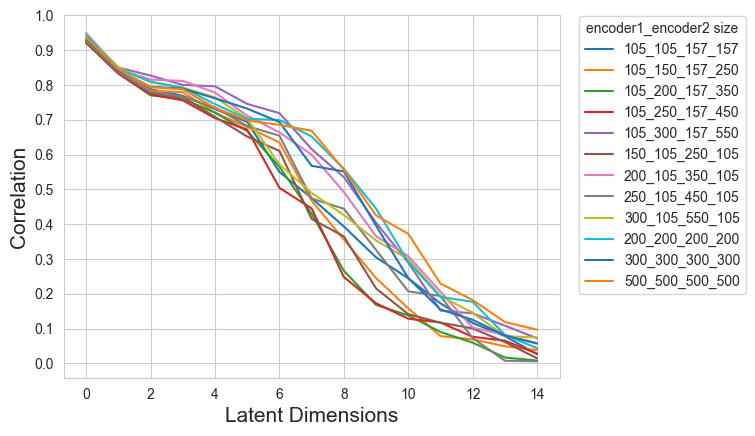

In [103]:
legends = []
fig, ax = plt.subplots(figsize=(6.4, 4.8),dpi=100)
sns.set_style('whitegrid')
for i in range(len(corr)):
    legend = f'{encoder1_size[i][0]}_{encoder1_size[i][1]}_{encoder2_size[i][0]}_{encoder2_size[i][1]}'
    legends.append(legend)
    
    y = corr[i][0]
    
    sns.lineplot(x=[x for x in range(len(y))],
                y=y)
plt.legend(labels=legends,loc=(1.04, 0.23),title='encoder1_encoder2 size')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
#plt.title('Test correlation across different latent dimensions', fontsize=15)
plt.show()
    #break

###### 7.3 Sort based on mean correlation for all the dimensions:

Top 2 and the last 2 will be selected for comparing their tanimotos.

In [27]:
# extract mean correlation along all the dimensions for each model
totals_mean = []
for key, val in corr.items():
    
    cor = np.mean(val[0]) # take average for all the dimensions
    
    totals_mean.append(cor)


In [28]:
# creat a df 
corr_df = pd.DataFrame({'corr':totals_mean,
                        'size': legends})

#sort them based on correlation attained

corr_df.sort_values(by='corr',ascending=False, inplace=True)
corr_df.head(5)

,corr,size
11,0.541787,500_500_500_500
4,0.533259,105_300_157_550
9,0.531759,200_200_200_200
6,0.519193,200_105_350_105
10,0.514778,300_300_300_300


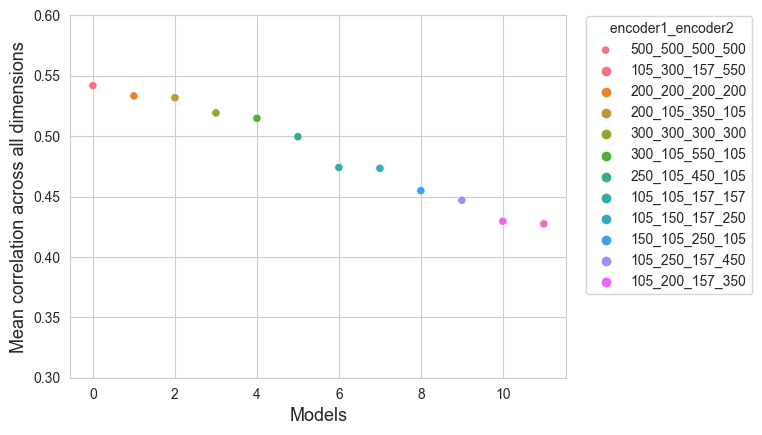

In [36]:
plt.figure(figsize=(6.4, 4.8),dpi=100)
sns.scatterplot(data=corr_df, y='corr', x=[x for x in range(len(totals_mean))], hue='size')
plt.legend(labels=corr_df['size'],loc=(1.04, 0.23),title=' encoder1_encoder2')
plt.xlabel('Models', fontsize=13)
plt.ylabel('Mean correlation across all dimensions', fontsize=13)
plt.ylim(0.3, 0.6)
plt.show()   

###### 7.4 Load the 4 selected models (top 2 and the last 2)

In [49]:
# loading the selected models
encoder1_size = [
    (500,500),
    (105,300),
    (105,250),
    (105,200)
    ]

encoder2_size = [
    (500,500),
    (157,550),
    (157,450),
    (157,350)
    ]


models = []

for i in range(len(encoder1_size)):
    # Initiate deepcca objec
    Models = DeepCCA(df_all)
    
    # generate data loaders and cca v1,v2
    Models.deepcca_dataloaders()

    
    # set the model layers based on what it was trained on
    Models.encoder_1_layers = encoder1_size[i]
    Models.encoder_2_layers = encoder2_size[i]
    
    
    # set up the encoders
    Models.deepcca_encoders()

    sdl = DCCA_SDL(latent_dims = Models.latent_dims,N=Models.N) # set up the model base
    
    # since the directory name is long lets predifine it before hand
    model_dir =  f'size_{encoder1_size[i][0]}_{encoder1_size[i][1]}_{encoder2_size[i][0]}_{encoder2_size[i][1]}'
    
    model = sdl.load_from_checkpoint(f'./sdl_logs/sdl_optimal_layer_size/{model_dir}/checkpoints/last.ckpt',
                                 
                                 latent_dims = Models.latent_dims, N=Models.N, 
                                 optimizer=Models.optim,
                                 encoders = [Models.encoder_1,Models.encoder_2],
                                 lam=0.0001, 
                                 dropout=0.05,
                                 objective=Models.objective
                                 )
    model.eval() # to drop randomness as mentioned in documentation
    models.append(model)

Global seed set to 15
Global seed set to 15
Global seed set to 15
Global seed set to 15


In [50]:
models[0] # check whether we loaded el models correctly

DCCA_SDL(
  (encoders): ModuleList(
    (0): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=200, out_features=500, bias=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
        (1): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=500, out_features=500, bias=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
      )
      (fc): Sequential(
        (0): Dropout(p=0, inplace=False)
        (1): Linear(in_features=500, out_features=15, bias=True)
      )
    )
    (1): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=300, out_features=500, bias=True)
          (2): LeakyReLU(negative_slope=0.01)
        )
        (1): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=500, out_features=500, bias=True)
        

###### 7.5 Tranform dataset using the selected el models

In [54]:

for i, model in enumerate(models):
        
    # transforma
    z1_test, z2_test = model.transform(loader=Models.test_loader) # get test z transformations
    z1_train, z2_train = model.transform(loader=Models.train_loader) # get train z transformations
    z1_val, z2_val = model.transform(loader=Models.val_loader) 
    
    
       #update the df with z score from the sdl_128
    # 1. update test_df
    Models.update_z_scores(dataset='test',z1=z1_test,
                       z2=z2_test, 
                       cols=[f'layer_size_top_{i+1}_z1',f'layer_size_top_{i+1}_z2']) # top 1... == the 1st selected model
    
    # 2. update train_df
    Models.update_z_scores(dataset='train',z1=z1_train,
                       z2=z2_train, 
                       cols=[f'layer_size_top_{i+1}_z1',f'layer_size_top_{i+1}_z2'])



    # 3. update val_df

    Models.update_z_scores(dataset='val',z1=z1_val,
                       z2=z2_val, 
                       cols=[f'layer_size_top_{i+1}_z1',f'layer_size_top_{i+1}_z2'])
    #break

    
    
    
#write the transformed df to file for the 
dfs = [Models.train_df, Models.test_df, Models.val_df]
paths = ['./sdl_logs/sdl_optimal_layer_size/train_df_max3_sdl_layer_size_optimised_z_scores.pickle',
         './sdl_logs/sdl_optimal_layer_size/test_df_max3_sdl_layer_size_optimised_z_scores.pickle',
         './sdl_logs/sdl_optimal_layer_size/val_df_max3_sdl_layer_size_optimised_z_scores.pickle'
        ]
for path, df in zip(paths,dfs):
    Files(path).write_to_file(df)

In [55]:
Models.val_df.head(3)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,layer_size_top_1_z1,layer_size_top_1_z2,layer_size_top_2_z1,layer_size_top_2_z2,layer_size_top_3_z1,layer_size_top_3_z2,layer_size_top_4_z1,layer_size_top_4_z2
18308,CC1(CCCCC1)C(=O)Nc2ccc(c(c2Cl)Cl)O,VDLGAVXLJYLFDH-UHFFFAOYSA-N,VDLGAVXLJYLFDH,spec_id16769,"[28.992814519957395, 9.93094121359686, -16.288...","[24.41728973388672, 18.567832946777344, 0.9911...","[1.1145527, -1.4718719, -1.1575501, 1.5242243,...",Benzene and substituted derivatives,"[-0.22787341, -0.5057002, -0.22532237, -0.2998...","[-0.34711027, -0.5340508, -0.38520005, 0.02647...","[-0.2201258, 0.7791507, -0.5952959, -0.0086150...","[-0.3161068, 0.625955, -0.60577464, 0.17473152...","[-0.7304936, -0.28945467, -0.2956073, 0.477101...","[-0.8764651, -0.3084482, -0.3359217, -0.449018...","[0.23220569, 0.53819597, 0.8709663, -0.0318686...","[0.3040182, -0.18885481, 0.66042054, -0.296837..."
16161,[H]N1C(=O)C([H])(C([H])([H])[H])C([H])(OC(=O)C...,VJYQPLSJYQMFHT-UHFFFAOYSA-N,VJYQPLSJYQMFHT,spec_id14610,"[7.295793570022209, 5.1959969017812835, 22.963...","[0.0, 0.0, 9.470010757446289, 54.8682708740234...","[3.5072234, -8.692439, -8.4471245, 5.7731876, ...",Peptidomimetics,"[3.2699282, -0.57910424, 0.11773235, -0.355928...","[4.406248, -0.404531, -0.31557962, -0.22630687...","[0.0910562, 0.5509389, -0.4245437, 0.13071564,...","[-0.17552155, -0.022934496, -0.15180397, 0.192...","[-0.04024625, 3.311855, 0.30818766, 0.4338398,...","[0.16758686, 3.878193, 0.70414186, 0.52185535,...","[0.23073134, -0.27691597, -0.28708053, 2.85923...","[0.040102124, 0.16196641, -0.648952, 3.7771494..."
39960,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CCC4[C@@]5(C...,IFIQVSCCFRXSJV-ZIZFEDMCSA-N,IFIQVSCCFRXSJV,spec_id39624,"[-56.619995935564326, -47.180565266411406, -28...","[0.0, 28.782299041748047, 21.592288970947266, ...","[-7.1055846, -1.823768, -5.0916753, -5.6632137...",Prenol lipids,"[0.057578944, 3.2052069, -0.17683041, 0.938788...","[-0.3361798, 1.3775645, 0.0005096197, 2.561767...","[-0.0940931, 1.8556808, 4.0298314, 0.7823971, ...","[-0.06518847, 0.3468852, 1.6350359, 0.43900406...","[2.5163274, -0.12980202, -1.5197893, -0.649240...","[0.46607867, -0.3921576, 0.9479388, -2.0718634...","[0.16177092, -0.4180844, -1.7954146, -0.174554...","[0.16454238, -1.5160103, -2.1730058, -0.756055..."


# 8. Optimise activation function


###### 8.1 Train models with the most commonly used activation functions: LeakyReLU, ReLU, Sigmoid, Tanh

In [70]:
# define activations to be tried
activations = [
            nn.LeakyReLU(), # already the default in cca_zoo
            nn.ReLU(),
            nn.Sigmoid(),
            nn.Tanh()
            ]

In [4]:
%%time
# train the models with different activations
model_logs = ['leakyrelu', 'relu','sigmoid', 'tanh']
corr = {}
for i, activation in enumerate(activations): #test number of hidden layers from 1:5
    
        print('\*'*21)
        print(f'\nSTARTING:  {activation}\n')
        print('/*'*21)
        
        # Initiate deepcca objec
        Models = DeepCCA(df_all)

        # generate data loaders and cca v1,v2
        Models.deepcca_dataloaders()
        
        
            
        # Set the activation
        Models.activation = activation
        
        
        Models.encoder_1_layers = (500,500) # since we found this attained the best correlation
        Models.encoder_2_layers = (500,500)
        
        
        # set up the encoders
        Models.deepcca_encoders()
    
        #set up logger
        version =  f'{model_logs[i]}'
   
        experiment_dir = './sdl_logs'
    
        model_checkpoint = ModelCheckpoint(save_last=True,
                                       monitor="val/l2",
                                       mode = 'min')
    
        logger = TensorBoardLogger(save_dir=experiment_dir, 
                                   name='sdl_optimal_activation',
                                   version = version)
        # train sdl
        Models.train_sdl(model_checkpoint, logger,enable_progress_bar=False) # disable progress bar to avoid crushing the notebook
        test_corr  = Models.score(model='sdl', dataset='test')
       
        # add test correlation to a dict
        if model_logs[i] not in corr.keys():
            corr[model_logs[i]] = []
            corr[model_logs[i]].append(test_corr)
        else:
            corr[model_logs[i]].append(test_corr)
Files('./sdl_logs/sdl_optimal_activation/test_correlation_for_activations.pickle').write_to_file(corr)

In [20]:
corr = Files('./sdl_logs/sdl_optimal_activation/test_correlation_for_activations.pickle').load_pickle()

###### 8.2 plot the test correlation attained

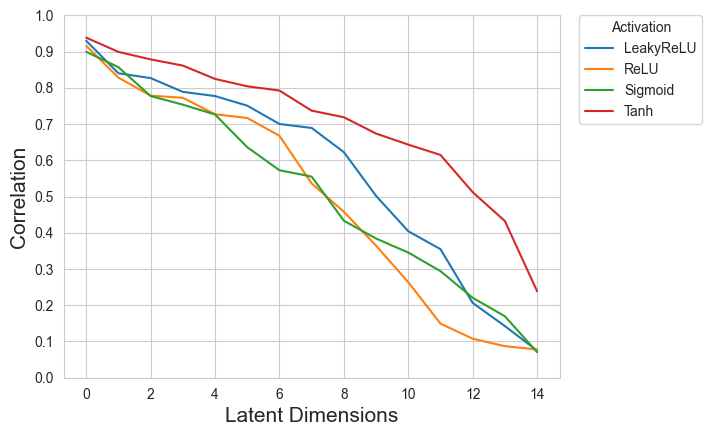

In [39]:
model_logs = ['leakyrelu', 'relu','sigmoid', 'tanh']
labels = ['LeakyReLU', 'ReLU','Sigmoid', 'Tanh']
palette = [sns.color_palette()[2],
           sns.color_palette()[0],
           sns.color_palette()[1],
           sns.color_palette()[3],
          ]
fig, ax = plt.subplots(figsize=(6.4, 4.8),dpi=100)
sns.set_style('whitegrid')
for i in range(len(corr)):
    
    
    y = corr[model_logs[i]][0]
    
    sns.lineplot(x=[x for x in range(len(y))], 
                 #palette= palette[i],
                y=y,
                palette= palette[i]
                )
plt.legend(labels=labels,loc=(1.04, 0.7),title='Activation')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.savefig('./sdl_logs/figures/activation_function_corr.pdf',format='pdf',
           transparent=False,bbox_inches = 'tight')
plt.show()
    #break

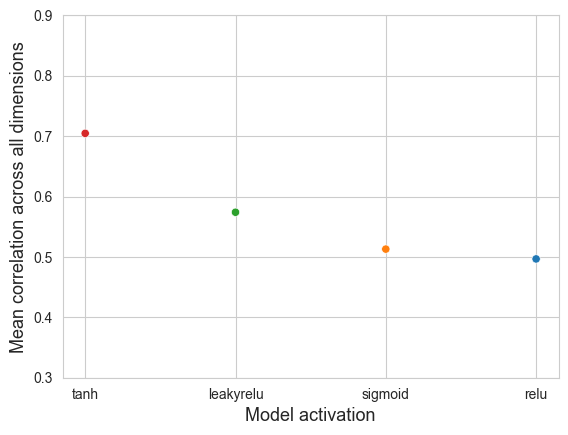

In [118]:
# extract mean correlation along all the dimensions for each model
totals_mean = []
for key, val in corr.items():
    
    cor = np.mean(val[0]) # take average for all the dimensions
    
    totals_mean.append(cor)
    
    
# creat a df 
corr_df = pd.DataFrame({'corr':totals_mean,
                        'activation': model_logs})

#sort them based on correlation attained

corr_df.sort_values(by='corr',ascending=False, inplace=True)
corr_df.head(5)

palette = [sns.color_palette()[3],
           sns.color_palette()[2],
           sns.color_palette()[1],
           sns.color_palette()[0],
          ]

plt.figure(figsize=(6.4, 4.8),dpi=100)
sns.scatterplot(data=corr_df, y='corr', x='activation', hue='activation', palette= palette,legend=False)
#plt.legend(loc=(1.04, 0.55),title='Activation')
plt.xlabel('Model activation', fontsize=13)
plt.ylabel('Mean correlation across all dimensions', fontsize=13)
plt.ylim(0.3, 0.9)
plt.show()   

###### 8.2 Load the trained models.

In [105]:
# define activations to be tried ( aslo needed when loading)
activations = [
            nn.LeakyReLU(), # already the default in cca_zoo
            nn.ReLU(),
            nn.Sigmoid(),
            nn.Tanh()
            ]


model_logs = ['leakyrelu', 'relu','sigmoid', 'tanh'] # will be needed to retrieve the logged model.
models = []
for i, activation in enumerate(activations):
    # Initiate deepcca objec
    Models = DeepCCA(df_all)
    
    # generate data loaders and cca v1,v2
    Models.deepcca_dataloaders()

    
    # set the model layers based on what it was trained on
    Models.encoder_1_layers = (500,500)
    Models.encoder_2_layers = (500,500)
    Models.activation = activation
    
    # set up the encoders
    Models.deepcca_encoders()

    sdl = DCCA_SDL(latent_dims = Models.latent_dims,N=Models.N) # set up the model base
  
  # load the model  
    model = sdl.load_from_checkpoint(f'./sdl_logs/sdl_optimal_activation/{model_logs[i]}/checkpoints/last.ckpt',
                                 
                                 latent_dims = Models.latent_dims, N=Models.N, 
                                 optimizer=Models.optim,
                                 encoders = [Models.encoder_1,Models.encoder_2],
                                 lam=0.0001, 
                                 dropout=0.05,
                                 objective=Models.objective
                                 )
    model.eval() # to drop randomness as mentioned in documentation
    models.append(model)
    #break

Global seed set to 15
Global seed set to 15
Global seed set to 15
Global seed set to 15


In [108]:
models[1]

DCCA_SDL(
  (encoders): ModuleList(
    (0): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=200, out_features=500, bias=True)
          (2): ReLU()
        )
        (1): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=500, out_features=500, bias=True)
          (2): ReLU()
        )
      )
      (fc): Sequential(
        (0): Dropout(p=0, inplace=False)
        (1): Linear(in_features=500, out_features=15, bias=True)
      )
    )
    (1): Encoder(
      (layers): Sequential(
        (0): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=300, out_features=500, bias=True)
          (2): ReLU()
        )
        (1): Sequential(
          (0): Dropout(p=0, inplace=False)
          (1): Linear(in_features=500, out_features=500, bias=True)
          (2): ReLU()
        )
      )
      (fc): Sequential(
        (0): Dro

###### 8.3 Transform the data set.

In [111]:
%%time
for i, model in enumerate(models):
        
    # transforma
    z1_test, z2_test = model.transform(loader=Models.test_loader) # get test z transformations
    z1_train, z2_train = model.transform(loader=Models.train_loader) # get train z transformations
    z1_val, z2_val = model.transform(loader=Models.val_loader) 
    
    
       #update the df with z score from the sdl_128
    # 1. update test_df
    Models.update_z_scores(dataset='test',z1=z1_test,
                       z2=z2_test, 
                       cols=[f'{model_logs[i]}_z1',f'{model_logs[i]}_z2']) 
    
    # 2. update train_df
    Models.update_z_scores(dataset='train',z1=z1_train,
                       z2=z2_train, 
                       cols=[f'{model_logs[i]}_z1',f'{model_logs[i]}_z2'])



    # 3. update val_df

    Models.update_z_scores(dataset='val',z1=z1_val,
                       z2=z2_val, 
                       cols=[f'{model_logs[i]}_z1',f'{model_logs[i]}_z2'])
   # break

    
    
    
#write the transformed df to file for the 
dfs = [Models.train_df, Models.test_df, Models.val_df]
paths = ['./sdl_logs/sdl_optimal_activation/train_df_max3_sdl_activation_optimised_z_scores.pickle',
         './sdl_logs/sdl_optimal_activation/test_df_max3_sdl_activation_optimised_z_scores.pickle',
         './sdl_logs/sdl_optimal_activation/val_df_max3_sdl_activation_optimised_z_scores.pickle'
        ]
for path, df in zip(paths,dfs):
    Files(path).write_to_file(df)

Wall time: 8.83 s


In [112]:
Models.val_df.head(2)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,leakyrelu_z1,leakyrelu_z2,relu_z1,relu_z2,sigmoid_z1,sigmoid_z2,tanh_z1,tanh_z2
18308,CC1(CCCCC1)C(=O)Nc2ccc(c(c2Cl)Cl)O,VDLGAVXLJYLFDH-UHFFFAOYSA-N,VDLGAVXLJYLFDH,spec_id16769,"[28.992814519957395, 9.93094121359686, -16.288...","[24.41728973388672, 18.567832946777344, 0.9911...","[1.1145527, -1.4718719, -1.1575501, 1.5242243,...",Benzene and substituted derivatives,"[-0.7029902, -0.14817622, -0.48123625, 0.26968...","[-0.12748098, -0.54248446, -0.1790152, -0.0151...","[-0.44993982, 0.13547057, 0.35290185, 0.455082...","[-0.39012057, 0.05024735, 0.7329963, 0.454123,...","[-0.9908092, -0.3927951, 0.747877, -0.17128468...","[0.19884229, 0.32907677, 0.41671145, -0.781387...","[-0.5665866, -0.39417094, -0.58390474, -1.1006...","[0.58770657, -0.009667635, -0.29627275, -0.546..."
16161,[H]N1C(=O)C([H])(C([H])([H])[H])C([H])(OC(=O)C...,VJYQPLSJYQMFHT-UHFFFAOYSA-N,VJYQPLSJYQMFHT,spec_id14610,"[7.295793570022209, 5.1959969017812835, 22.963...","[0.0, 0.0, 9.470010757446289, 54.8682708740234...","[3.5072234, -8.692439, -8.4471245, 5.7731876, ...",Peptidomimetics,"[-0.97442293, 0.012245387, -0.23954043, 0.3111...","[-0.3816018, -0.1473596, -0.052980512, -0.5040...","[2.276792, -0.0463333, 0.09992445, -2.3053753,...","[3.4932628, 0.14210054, -0.884035, -3.3034284,...","[-0.6141832, 0.011068463, -0.011655569, 0.0716...","[-0.5665219, 0.8074746, -1.3161016, 0.8810036,...","[-0.4352209, -0.10598579, 0.37118778, -0.41577...","[0.21903086, 0.4234221, -0.41617775, 0.142596,..."


In [ ]:
### Unify identified params:

In [7]:
%%time
# Initiate deepcca objec
Models = DeepCCA(df_all)

# generate data loaders and cca v1,v2
Models.deepcca_dataloaders()

# set encoders
Models.deepcca_encoders()

#set up logger
version =  f'dims_100_tanh_3_hiddens'
   
experiment_dir = './sdl_logs'

# define the logs
model_checkpoint = ModelCheckpoint(save_last=True,
                                       monitor="val/l2",
                                       mode = 'min')
    
logger = TensorBoardLogger(save_dir=experiment_dir, 
                                   name='unified_params',
                                   version = version)
# train sdl
Models.train_sdl(model_checkpoint, logger,enable_progress_bar=True) 


In [140]:
train_corr  = Models.score(model='sdl', dataset='train')
test_corr  = Models.score(model='sdl', dataset='test')

In [144]:
test_corr[:10].mean()

0.893639174518681

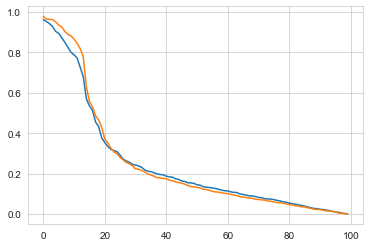

In [143]:
#the dimensions probably there is no harm in adding more dims; 
#and using less does not also harm. adding does not take away the information obtained neither does it add any info
# this could explain why the change in dims was not sensitive
sns.set_style('whitegrid')
sns.lineplot(y=test_corr, x = [x for x in range(100)])
sns.lineplot(y=train_corr, x = [x for x in range(100)])
plt.show()

# XX. Testing SDL whith non-high-scoring queries

In [102]:
#step 1: load sdl 15 dims; 768 batch size model
sdl = DCCA_SDL(latent_dims = Models.latent_dims,N=Models.N) # set up the model base

sdl_768 = sdl.load_from_checkpoint(f'./sdl_logs/sdl_optimal_batch_size/sdl_run_768_only_backup/checkpoints/last.ckpt',
                                 
                                 latent_dims = Models.latent_dims, N=Models.N, 
                                 optimizer=Models.optim,
                                 encoders = [Models.encoder_1,Models.encoder_2],
                                 lam=0.0001, 
                                 dropout=0.05,
                                 objective=Models.objective
                                 )
sdl_768.eval()


#step: 2 Transform the test data excluding high scoring queries 
test_df_after_exclusion = Files('./sdl_768_15_dims/test_df_excluding_non_high_scoring_queries.pickle').load_pickle()

#update only the new test set

#creat test loader for the new test set (new_test == test data excluding high scoring queries)
v1_new_test = np.array([x for x in test_df_after_exclusion['ms2ds']])
v2_new_test = np.array([x for x in test_df_after_exclusion['mol2vec']])

test_dataset = CCA_Dataset([v1_new_test, v2_new_test])
test_loader = get_dataloaders(test_dataset,\
                                      batch_size= 768, # since the model was trained on 768 batch size
                                      num_workers=6,drop_last=False)


#step: 3 Transform the test data excluding high scoring queries
z1_test, z2_test = sdl_768.transform(loader=test_loader) # get test z transformations

# step 4: add the z-scores to the new test df 

test_df_after_exclusion['sdl_exclusion_z1'] = [x for x in z1_test]
test_df_after_exclusion['sdl_exclusion_z2'] = [x for x in z2_test]

# write the df to file for cosine distance calculations
# Files('./sdl_768_15_dims/retransformed_test_df_excluding_non_high_scoring_queries.pickle').write_to_file(test_df_after_exclusion)

In [69]:
test_df_after_exclusion.head(5)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,cca_z1,cca_z2,sdl_768_z1,sdl_768_z2,sdl_768_tanimoto,sdl_exclusion_z1,sdl_exclusion_z2
5625,COc1ccc(cc1OC)C(=O)NCc2ccc(OCCN(C)C)cc2,QQQIECGTIMUVDS-UHFFFAOYSA-N,QQQIECGTIMUVDS,spec_id5019,"[0.7660381606480904, -2.9954168988462215, -12....","[0.0, 13.000274658203125, 0.35151147842407227,...","[-0.45550603, -3.2559516, -3.0893652, 5.457150...",Benzene and substituted derivatives,"[0.05153173450592052, -0.6290144322197803, 0.3...","[-0.36705695389751064, -0.7741333930770977, 0....","[0.89759576, -0.44103494, 0.25500268, -0.23932...","[0.8142293, -0.8455215, 0.10232448, 0.03982669...",0.3434,"[0.91412747, -0.45944878, 0.22894204, -0.27499...","[0.87694925, -0.8284457, 0.11323702, 0.0347905..."
40023,COc1cc(OC)c2c(OC)c(-c3ccc4c(c3)OCO4)c(=O)oc2c1,PZYZNVLXKYMURF-UHFFFAOYSA-N,PZYZNVLXKYMURF,spec_id39710,"[4.160680518910307, -17.534900146210205, -20.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 63.7232666015625, 5....","[1.2124093, -3.7327924, -5.30343, 5.8895183, 0...",Isoflavonoids,"[-0.5501047970140038, 0.38237380310465097, 0.3...","[-0.4201982466068921, -0.10796739852068316, -0...","[-1.9857152, 0.01580453, 0.34879375, -0.063378...","[-2.6851432, 0.07175583, 0.100825734, -0.03386...",0.5405,"[-2.011728, 0.038822383, 0.31981504, -0.077062...","[-2.6763551, 0.09979546, 0.111880705, -0.04374..."
24733,O=C(OC1C(OC(OCCC2=CC=C(O)C(O)=C2)C(OC(=O)C)C1O...,ALERZNQPBWWLMW-UHFFFAOYSA-N,ALERZNQPBWWLMW,spec_id23060,"[-4.41229641164563, -6.063199486461368, 5.2722...","[2.8529367446899414, 9.61679458618164, 15.8730...","[1.791454, -10.160973, -14.062275, 4.4526644, ...",Cinnamic acids and derivatives,"[-0.4426021969600858, 1.809169159153108, -1.36...","[-0.045717320727094835, 0.8496795834228216, -1...","[0.23103917, 1.7803116, 0.6962889, -0.04533320...","[1.5970452, 0.87056667, 0.012284648, 0.0887110...",0.4717,"[0.23773558, 1.9633561, 0.6564988, -0.05676257...","[1.6718297, 0.9081541, 0.03175423, 0.08688891,..."
25593,O=C(OCC=1C=CC=CC1)NC(C(=O)OC=2C=CC3=C(OC(=O)C(...,LNMBUJUJPICZGH-UHFFFAOYSA-N,LNMBUJUJPICZGH,spec_id25480,"[-1.5422615221495586, 10.45036605430372, -7.52...","[0.0, 0.0, 18.23489761352539, 0.0, 0.0, 0.0, 0...","[0.47904763, -4.99688, -7.802119, 13.313987, -...",Carboxylic acids and derivatives,"[-0.15315980785614414, 0.6710302381269899, -1....","[-0.3503366506823893, -0.04045601704619821, -0...","[-0.007887766, 0.32609048, 2.6567798, 0.227693...","[1.1675563, -0.09879863, 1.4980595, -0.1577402...",0.6382,"[-0.0047168285, 0.37724876, 2.5559943, 0.25037...","[1.2357216, -0.07279754, 1.3763267, -0.1757656..."
40227,CNc1ccccc1C(=O)N1CCc2c([nH]c3ccccc23)C1=O,RAEOYMOPVHBBKE-UHFFFAOYSA-N,RAEOYMOPVHBBKE,spec_id39955,"[11.776328909052227, 20.7505544911708, 19.9699...","[0.0, 0.0, 0.0, 0.0, 0.0, 9.018969535827637, 0...","[2.4732747, -4.1783967, -4.060229, 5.6195107, ...",Indoles and derivatives,"[-0.0840467761011092, 0.07684710551968574, 1.2...","[-0.4877804917430576, -0.940284281828943, -0.5...","[0.4848546, -0.24852234, 0.17956558, 0.0758979...","[0.9901773, -0.58074486, 0.41434932, 0.0546230...",0.4668,"[0.49529618, -0.24947684, 0.15585193, 0.079614...","[1.0556089, -0.56050426, 0.3956082, 0.05055973..."


In [7]:
# # loading for the best model
# z1_test, z2_test = sdl_768.transform(loader=Models.test_loader) # get test z transformations
# z1_train, z2_train = sdl_768.transform(loader=Models.train_loader) # get train z transformations
# z1_val, z2_val = sdl_768.transform(loader=Models.val_loader) # get train z transformations


#     #update the df with z score from the sdl_128
#     # 1. update test_df
# Models.update_z_scores(dataset='test',z1=z1_test,
#                        z2=z2_test, 
#                        cols=['sdl_768_z1','sdl_768_z2'])
#     # 2. update train_df
# Models.update_z_scores(dataset='train',z1=z1_train,
#                        z2=z2_train, 
#                        cols=['sdl_768_z1','sdl_768_z2'])

#     # 3. update val_df

# Models.update_z_scores(dataset='val',z1=z1_train,
#                        z2=z2_train, 
#                        cols=['sdl_768_z1','sdl_768_z2'])

In [24]:
#only worked if its cca and sdl!!!!!!!
Models.val_df.head(3) #check that updates are okay: only worked if its cca and sdl!!!!!!!

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,sdl_768_z1,sdl_768_z2,cca_z1,cca_z2
18308,CC1(CCCCC1)C(=O)Nc2ccc(c(c2Cl)Cl)O,VDLGAVXLJYLFDH-UHFFFAOYSA-N,VDLGAVXLJYLFDH,spec_id16769,"[28.992814519957395, 9.93094121359686, -16.288...","[24.41728973388672, 18.567832946777344, 0.9911...","[1.1145527, -1.4718719, -1.1575501, 1.5242243,...",Benzene and substituted derivatives,"[-0.028206334, -0.58697754, -0.27564368, 0.387...","[0.1807306, -0.6496799, -0.6295585, 0.15014616...","[-0.18367801964301914, -0.5168160022883642, 0....","[-0.1445210560271232, -0.8005949459704749, 0.4..."
16161,[H]N1C(=O)C([H])(C([H])([H])[H])C([H])(OC(=O)C...,VJYQPLSJYQMFHT-UHFFFAOYSA-N,VJYQPLSJYQMFHT,spec_id14610,"[7.295793570022209, 5.1959969017812835, 22.963...","[0.0, 0.0, 9.470010757446289, 54.8682708740234...","[3.5072234, -8.692439, -8.4471245, 5.7731876, ...",Peptidomimetics,"[1.4329386, -0.23577894, 0.42023522, 0.1479506...","[1.5159718, 0.1765452, -0.11394979, -0.0296348...","[-0.006435331845283554, 0.058462411914186246, ...","[0.20256939799957618, 0.9827796658564947, 0.12..."
39960,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CCC4[C@@]5(C...,IFIQVSCCFRXSJV-ZIZFEDMCSA-N,IFIQVSCCFRXSJV,spec_id39624,"[-56.619995935564326, -47.180565266411406, -28...","[0.0, 28.782299041748047, 21.592288970947266, ...","[-7.1055846, -1.823768, -5.0916753, -5.6632137...",Prenol lipids,"[0.34851214, 3.2085502, -0.1975606, 0.06998302...","[0.28839505, 1.744373, -0.14316656, -9.870529e...","[0.1570637440121694, 2.022003197058803, 0.1190...","[0.07726268614751708, 1.7868799202767538, 0.86..."


<h1> Train the final Model with optimised parameters<h1>

In [12]:
%%time
# Initiate the DeepCCA oject
Models = DeepCCA(df_all)

# generate data loaders and cca v1,v2
Models.deepcca_dataloaders()

    # set up the encoders
Models.deepcca_encoders()
    
    # train cca
Models.train_cca() 

#set up logger for deepcca
version =  'final_model'
   
experiment_dir = './sdl_logs'
    
model_checkpoint = ModelCheckpoint(save_last=True,
                                       monitor="val/l2",
                                       mode = 'min')
    
logger = TensorBoardLogger(save_dir=experiment_dir, 
                                   name='sdl_optimized_params',
                                   version = version)
        # train sdl
Models.train_sdl(model_checkpoint, logger,enable_progress_bar=True) 

#calculate the correlations

#cca

    #train correlation
cca_train_corr  = Models.score(model='cca', dataset='train')

    #test correlation
cca_test_corr  = Models.score(model='cca', dataset='test')


#DeepCCA

    #train correlation
    
deepcca_train_corr  = Models.score(model='sdl', dataset='train')

    #test correlation
deepcca_test_corr  = Models.score(model='sdl', dataset='test')


# Transform the dataset. (calculate the z scores)

#cca
Models.transform(model='cca', dataset='train')
Models.transform(model='cca', dataset='test')
Models.transform(model='cca', dataset='val')

#deepcca
Models.transform(model='sdl', dataset='train')
Models.transform(model='sdl', dataset='test')
Models.transform(model='sdl', dataset='val')


#write the transformed df to file for the 
dfs = [Models.train_df, Models.test_df, Models.val_df]
paths = ['./sdl_logs/sdl_optimized_params/train_df_max3_sdl_and_cca_final_model_z_scores.pickle',
         './sdl_logs/sdl_optimized_params/test_df_max3_sdl_and_cca_final_model_z_scores.pickle',
         './sdl_logs/sdl_optimized_params/val_df_max3_sdl_and_cca_final_model_z_scores.pickle'
        ]
for path, df in zip(paths,dfs):
    Files(path).write_to_file(df)
    
# write correlations to file

correlations_df = pd.DataFrame({'cca_train_corr': cca_train_corr,
                                'cca_test_corr': cca_test_corr,
                                'deepcca_train_corr': deepcca_train_corr,
                                'deepcca_test_corr': deepcca_test_corr})

Files('./sdl_logs/sdl_optimized_params/final_model_cca_and_sdl_max3_correlation_df.pickle').write_to_file(correlations_df)


 -------------------- 
 Training CCA
 --------------------


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 852 K 
1 | mse      | MSELoss    | 0     
2 | bns      | ModuleList | 0     
----------------------------------------
852 K     Trainable params
0         Non-trainable params
852 K     Total params
3.409     Total estimated model params size (MB)



 -------------------- 
 Training SDL
 --------------------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [16]:
correlations_df.head()

,cca_train_corr,cca_test_corr,deepcca_train_corr,deepcca_test_corr
0,0.985337,0.695807,0.990053,0.999994
1,0.980327,0.415773,0.961795,0.999995
2,0.978053,0.432494,0.928001,0.999897
3,0.976693,0.403096,0.899712,0.999686
4,0.975939,0.355498,0.874949,0.999529


#### Seems dims of 10 are better train with 10 dims and see tanis

In [16]:
#this one will go out !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# latent_dims te deepcca objec
Models = DeepCCA(df_all)
    
    #set the latent dimentions to dim
Models.latent_dims = 10
    
    # generate data loaders and cca v1,v2
Models.deepcca_dataloaders()

    # set up the encoders
Models.deepcca_encoders()
    
    # train cca
Models.train_cca() # will look at this for opti

    # score the models: it runs cca.score

cca_train_corr = Models.score(model='cca', dataset='train')
cca_test_corr = Models.score(model='cca', dataset='test')
    #cca transform: runs cca.transform and update the df with z scores
# Models.transform(model='cca', dataset='train')
# Models.transform(model='cca', dataset='test')

    #corr.append([f'cca_dims_{dim}',cca_train_corr, cca_test_corr])
    
  


 -------------------- 
 Training CCA
 --------------------


In [5]:
%reload_ext tensorboard
%tensorboard --logdir= './sdl/lightning_logs' --host localhost --port 8088
    # train sdl
Models.train_sdl() # will look at this for opti

    # score the models: it runs sdl.score()

sdl_train_corr =Models.score(model='sdl', dataset='train')
sdl_test_corr = Models.score(model='sdl', dataset='test')
    
    #sdl transform: runs sdl.transform and update the df with z scores
# Models.transform(model='sdl', dataset='train')
# Models.transform(model='sdl', dataset='test')

    #corr.append([f'sdl_dims_{dim}',sdl_train_corr, sdl_test_corr])

    


In [84]:
# train dcca
Models.train_sdl() # will look at this for opti

# score the models: it runs dcca.score()

sdl_train_corr =Models.score(model='sdl', dataset='train')
sdl_test_corr = Models.score(model='sdl', dataset='test')
    
#dcca transform: runs dcca.transform and update the df with z scores
Models.transform(model='sdl', dataset='train')
Models.transform(model='sdl', dataset='test')
   
    #corr.append([f'dcca_dims_{dim}',dcca_train_corr, dcca_test_corr])

In [42]:
#write corr to file
path = './testing_dims_corr_only_test_corr.pickle'
Files(path).write_to_file(corr)

In [39]:
# To construct image name
embedding = 'MS2DeepScore'
method = 'SDL_as_DeepCCA_hidden_opt_lr_dim_10'
data = 'max3'
dims = 10 #latent_dims

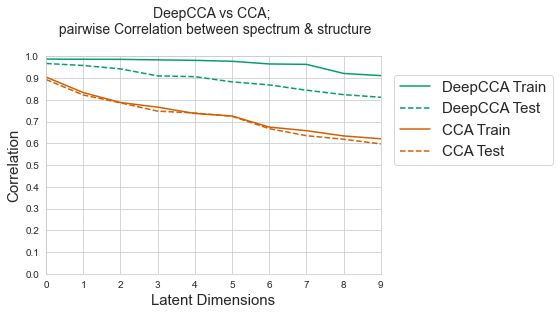

In [44]:
dims = 10
# plot train correlation vs test correlation
x=[x for x in range(dims)]
fig, ax = plt.subplots()

sns.set_style('whitegrid')

line = ['solid', 'dashed']

#justice for the color blind :)
palette = [#sns.color_palette("colorblind")[4],\
           sns.color_palette("colorblind")[2],\
           sns.color_palette("colorblind")[3]]

dfs = [#[dcca_train_corr, dcca_test_corr],\
       [sdl_train_corr, sdl_test_corr],\
       [cca_train_corr,cca_test_corr]]

for i, df in enumerate(dfs):
    #train
    sns.lineplot(x=[x for x in range(10)],y=df[0], \
                 color = palette[i],
                 linestyle=line[0],ax=ax)
    #test
    sns.lineplot(x=x,y=df[1],\
                 color = palette[i],
                 linestyle=line[1], ax=ax)

    plt.legend(labels=[#'DCCA Train', 'DCCA Test',\
                      'DeepCCA Train', 'DeepCCA Test',\
                      'CCA Train', 'CCA Test'], \
                       loc=(1.04, 0.5),\
                    fontsize=15)#title='Algorithm', 
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.ylim(0, 1.0)
plt.title(label=f'DeepCCA vs CCA; \n pairwise Correlation between spectrum & structure\n',\
          fontsize=14,loc='center')
plt.xlim(0, 9)
plt.xticks(np.arange(0, 9.01, step=1))
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.savefig(f'../plots/{method}_{data}_{dims}_vs_cca_{embedding}.png',\
           transparent=False,bbox_inches = 'tight')
plt.show()

#what is the probability that dcca and sdl are ~ the same; something wrong?


In [164]:
len(dcca_train_corr)

10

In [33]:
#write dfs (with the z score from dcca,cca and sdl) to file

dfs = [Models.train_df,Models.test_df,Models.val_df]

# paths = ['./max3_sdl_dims_10_best_train_df_with_z.pickle',
#         './max3_sdl_dims_10_test_df_with_z.pickle',
#         './max3_sdl_dims_10_val_df_with_z.pickle']

paths = ['./max3_sdl_cca_dims_15_train_df_with_z.pickle',
        './max3_sdl_cca_dims_15_test_df_with_z.pickle',
        './max3_sdl_cca_dims_15_val_df_with_z.pickle']

for df, path in zip(dfs,paths):
    Files(path).write_to_file(df)
    

In [25]:

paths = ['./max3_sdl_dims_10_best_train_df_with_z.pickle',
        './max3_sdl_dims_10_test_df_with_z.pickle',
        './max3_sdl_dims_10_val_df_with_z.pickle']

train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()


,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,sdl_768_z1,sdl_768_z2,cca_z1,cca_z2
18308,CC1(CCCCC1)C(=O)Nc2ccc(c(c2Cl)Cl)O,VDLGAVXLJYLFDH-UHFFFAOYSA-N,VDLGAVXLJYLFDH,spec_id16769,"[28.992814519957395, 9.93094121359686, -16.288...","[24.41728973388672, 18.567832946777344, 0.9911...","[1.1145527, -1.4718719, -1.1575501, 1.5242243,...",Benzene and substituted derivatives,"[-0.028206334, -0.58697754, -0.27564368, 0.387...","[0.1807306, -0.6496799, -0.6295585, 0.15014616...","[-0.18367801964301914, -0.5168160022883642, 0....","[-0.1445210560271232, -0.8005949459704749, 0.4..."
16161,[H]N1C(=O)C([H])(C([H])([H])[H])C([H])(OC(=O)C...,VJYQPLSJYQMFHT-UHFFFAOYSA-N,VJYQPLSJYQMFHT,spec_id14610,"[7.295793570022209, 5.1959969017812835, 22.963...","[0.0, 0.0, 9.470010757446289, 54.8682708740234...","[3.5072234, -8.692439, -8.4471245, 5.7731876, ...",Peptidomimetics,"[1.4329386, -0.23577894, 0.42023522, 0.1479506...","[1.5159718, 0.1765452, -0.11394979, -0.0296348...","[-0.006435331845283554, 0.058462411914186246, ...","[0.20256939799957618, 0.9827796658564947, 0.12..."
39960,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CCC4[C@@]5(C...,IFIQVSCCFRXSJV-ZIZFEDMCSA-N,IFIQVSCCFRXSJV,spec_id39624,"[-56.619995935564326, -47.180565266411406, -28...","[0.0, 28.782299041748047, 21.592288970947266, ...","[-7.1055846, -1.823768, -5.0916753, -5.6632137...",Prenol lipids,"[0.34851214, 3.2085502, -0.1975606, 0.06998302...","[0.28839505, 1.744373, -0.14316656, -9.870529e...","[0.1570637440121694, 2.022003197058803, 0.1190...","[0.07726268614751708, 1.7868799202767538, 0.86..."
20518,CCOC(=O)c1c(CSc2ccc(C)cc2)n(C)c2cc(Br)c(OC(C)=...,NTBRBRYSWHMBTI-UHFFFAOYSA-N,NTBRBRYSWHMBTI,spec_id21096,"[4.0410194627677285, 7.988557117162137, -0.984...","[9.632440567016602, 3.5340728759765625, 18.387...","[2.3850176, -2.2419546, -4.7798896, 6.514888, ...",Indoles and derivatives,"[0.1305097, -0.48955625, -1.7252398, 0.1109124...","[-0.10473886, -0.19882882, -1.872568, 0.110222...","[-0.5785258385811215, -0.8347664433452764, -0....","[-0.6361535897057551, -0.5815054845342418, -0...."
1636,CC1=CC=C(C=C1)C(=O)C(C)NC,YELGFTGWJGBAQU-UHFFFAOYSA-N,YELGFTGWJGBAQU,spec_id1586,"[12.42601229142216, 8.474520761408343, 30.5386...","[0.0, 0.0, 6.7381978034973145, 32.302322387695...","[0.8318524, -0.79777485, -2.3919985, 2.6826973...",Organooxygen compounds,"[0.8457458, -1.1315978, 0.43432468, 0.31582084...","[0.7193668, -0.9291076, 0.038362436, 0.1387279...","[-0.2544740282257761, -0.8955232493837665, 0.3...","[-0.26825048158889175, -1.075657212286704, 0.6..."
